# Data Analytics SoSe 2021
## Gruppenmitglieder: Anja Stricker, Annika Stadelmann

### Inhaltsverzeichnis

* [Aufgabe 1](#aufgabe1)

### Aufgabe 1 <a id="aufgabe1"></a>
#### (Datenvorbereitung)
Lesen Sie den unter der o.g. Adresse verfugbaren Tankstellendatensatz zum Stand 31.05.2021
in einen DataFrame namens df stations ein. Dieser soll in dieser Aufgabe fur die weitere
Verwendung vorbereitet werden.

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="DA_stud")
import json
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

df_stations = pd.read_csv("2021-05-31-stations.csv")
df_stations.head()

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json
0,0e18d0d3-ed38-4e7f-a18e-507a78ad901d,OIL! Tankstelle München,OIL!,Eversbuschstraße 33,NaN,80999,München,48.180700,11.460900,1970-01-01 01:00:00+01,"{""openingTimes"":[{""applicable_days"":192,""perio..."
1,44e2bdb7-13e3-4156-8576-8326cdd20459,bft Tankstelle,NaN,Schellengasse,53,36304,Alsfeld,50.752009,9.279039,1970-01-01 01:00:00+01,"{""openingTimes"":[{""applicable_days"":63,""period..."
2,ad812258-94e7-473d-aa80-d392f7532218,bft Bonn-Bad Godesberg,bft,Godesberger Allee,55,53175,Bonn,50.695100,7.142760,1970-01-01 01:00:00+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
3,e52d755d-4be7-4962-a917-3b0139e6f352,Esso Tankstelle,ESSO,OSNABRUECKER STR. 5,,49163,BOHMTE,52.358250,8.304064,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
4,e52a5d92-33c6-4c77-b6cd-ea90ca1c7c62,Friedrich Dankelmann,Markant,Strangenhäuschen,10,52070,Aachen,50.801680,6.110960,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":63,""period..."


a) Untersuchen Sie den Datensatz auf fehlende Werte und setzen Sie ggf. eine geeignete Strategie um, um mit diesen zu verfahren. Begrunden Sie Ihr Vorgehen.

In [30]:
df_stations.isnull().sum()

uuid                    0
name                    0
brand                 670
street                  3
house_number         2940
post_code               3
city                    4
latitude                0
longitude               0
first_active            0
openingtimes_json       0
dtype: int64

Im folgenden werden nur noch die Spalten betrachtet die einen NaN Wert über 0 haben.
Alle Spalten mit 0 haben keine NaN Werte und müssen demnach nicht nochmal kontrolliert werden.

NaN Werte werden durch passende andere Werte ersetzt.

In [31]:
df_stations["brand"] = df_stations["brand"].fillna("other")
df_stations["openingtimes_json"] = df_stations["openingtimes_json"].replace("{}", "empty")
# df_stations["post_code"] = df_stations["post_code"].apply(lambda x: pd.to_numeric(x, errors='coerce').astype(np.int64)).dropna()

In [32]:
df_stations.isnull().sum()

uuid                    0
name                    0
brand                   0
street                  3
house_number         2940
post_code               3
city                    4
latitude                0
longitude               0
first_active            0
openingtimes_json       0
dtype: int64

Jetzt werden fehlende Einträge von street, house_number, city und post_code mit geopy ermittelt und ersetzt.

In [26]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="DA_stud")
# df = pd.DataFrame()

# for i in df_stations.loc[df_stations["street"].isnull() | df_stations["house_number"].isnull() | df_stations["city"].isnull() | df_stations["post_code"].isnull()].index:
#     data = df_stations.iloc[i]
#     if ((data["latitude"] <= 90.0) & (data["latitude"] >= -90.0) & (data["longitude"] <= 180.0) & (data["longitude"] >= -180.0) 
#     & (data["latitude"] != 0.0) & (data["longitude"] != 0.0)):
#         location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
#         adressData = location.raw["address"]
#         if "road" in adressData:
#             df_stations.at[i, "street"] = adressData["road"]
#         if "house_number" in adressData:
#             df_stations.at[i, "house_number"] = adressData["house_number"]
#         if "town" in adressData:
#             df_stations.at[i, "city"] = adressData["town"]
#         if "postcode" in adressData:
#             df_stations.at[i, "post_code"] = adressData["postcode"]

# df_stations[df_stations["city"].isnull()]

In [33]:
df = pd.DataFrame()

for i in tqdm(df_stations.loc[df_stations["street"].isnull() | df_stations["city"].isnull() | df_stations["post_code"].isnull()].index):
    data = df_stations.iloc[i]
    if ((data["latitude"] <= 90.0) & (data["latitude"] >= -90.0) & (data["longitude"] <= 180.0) & (data["longitude"] >= -180.0) 
    & (data["latitude"] != 0.0) & (data["longitude"] != 0.0)):
        location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
        adressData = location.raw["address"]
        if "road" in adressData:
            df_stations.at[i, "street"] = adressData["road"]
        if "town" in adressData:
            df_stations.at[i, "city"] = adressData["town"]
        if "postcode" in adressData:
            df_stations.at[i, "post_code"] = adressData["postcode"]

100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


In [28]:
for i in tqdm(df_stations.loc[df_stations["house_number"].isnull()].index):
    data = df_stations.iloc[i]
    if ((data["latitude"] <= 90.0) & (data["latitude"] >= -90.0) & (data["longitude"] <= 180.0) & (data["longitude"] >= -180.0) 
    & (data["latitude"] != 0.0) & (data["longitude"] != 0.0)):
        location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
        adressData = location.raw["address"]
        if "house_number" in adressData:
            df_stations.at[i, "house_number"] = adressData["house_number"]

  1%|          | 31/2940 [00:15<24:02,  2.02it/s]


KeyboardInterrupt: 

In [151]:
df_stations["street"] = df_stations["street"].fillna("")
df_stations["post_code"] = df_stations["post_code"].fillna(0)
df_stations["city"] = df_stations["city"].fillna("")

df_stations.isnull().sum()

uuid                    0
name                    0
brand                   0
street                  0
house_number         1122
post_code               0
city                    0
latitude                0
longitude               0
first_active            0
openingtimes_json       0
dtype: int64

In [152]:
for i in tqdm(df_stations.loc[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)].index):
    data = df_stations.iloc[i]

    if ((data["street"] != "") & (data["post_code"] != "") & (data["city"] != "")):

        #address we need to geocode
        loc = (data["street"] + " " + data["post_code"] + " " + data["city"])
        print(loc)
        
        #applying geocode method to get the location
        location = geolocator.geocode(loc)
        
            #printing address and coordinates
            # print(location.address)
            # print((location.latitude, location.longitude))
        

        if location != None:
            df_stations.at[i, "latitude"] = location.latitude
            df_stations.at[i, "longitude"] = location.longitude

 10%|█         | 1/10 [00:00<00:01,  5.41it/s]please delete - bitte loeschen 00000 please delete - bitte loeschen
Talstraße 26 58332 Schwelm
100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


In [153]:
df_stations.loc[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)]

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json
12191,183311cd-53cd-4779-a829-3f91a0e2c3e8,please delete - bitte loeschen,other,please delete - bitte loeschen,0,00000,please delete - bitte loeschen,0.0,0.0,2014-03-18 16:45:31+01,empty
14200,4e8ecfc5-5d0d-4463-901b-6b9ff8fee510,01_test,other,,NaN,0,,0.0,0.0,2015-05-27 00:00:01+02,empty
16074,ce830342-ebca-4bf8-9593-653341732a59,Hh Admi-Testkasse,OIL!,Admi55,NaN,12345,Hh Admi-Testkasse,0.0,0.0,2020-09-16 08:01:15+02,empty


In [155]:
df_stations.drop(df_stations[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)].index, inplace=True)

In [156]:
df_stations["post_code"] = df_stations["post_code"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df_stations.dropna(subset = ["post_code"], inplace=True)
np.isnan(df_stations['post_code']).sum()
df_stations["post_code"] = df_stations["post_code"].astype(np.int64)
# TODO nach oben

Prüfen ob Cities NaN sind

Einträge die City, Post_Code und Coordinaten NaN haben werden gelöscht.

Citys die einen NaN Wert haben, aber einen Postcode, werden mit den anderen Postcode einträgen verglichen und erhalten den Namen der City.

In [157]:
def findCityWithPostcode(row):
    test = df_stations["city"][(df_stations["post_code"] == row["post_code"]) & (df_stations["city"].notnull())].item()
    if (len(test) > 0):
        return test
    else:
        return ""
df_stations["city"] = df_stations[["city", "post_code"]].apply(lambda x: findCityWithPostcode(x) if x["city"] is np.nan else x["city"], axis=1)

In [158]:
df_stations["house_number"] = df_stations["house_number"].fillna(0)
df_stations = df_stations.dropna(subset=["city"])
df_stations.isnull().sum()

uuid                 0
name                 0
brand                0
street               0
house_number         0
post_code            0
city                 0
latitude             0
longitude            0
first_active         0
openingtimes_json    0
dtype: int64

b) Transformieren Sie die Spalten brand, street und city, sodass die Werte jeweils nur
in Großbuchstaben ausgeben werden.

In [159]:
df_stations["brand"] = df_stations["brand"].str.upper()
df_stations["street"] = df_stations["street"].str.upper()
df_stations["city"] = df_stations["city"].str.upper()

In [160]:
df_stations["city"] = df_stations["city"].str.replace(u"Ü", "UE")
df_stations["city"] = df_stations["city"].str.replace(u"Ö", "OE")
df_stations["city"] = df_stations["city"].str.replace(u"Ä", "AE")

c) Uberprüfen Sie, ob der Datensatz Duplikate enth ¨ alt und entfernen Sie diese ggf. Ein Dupli- ¨
kat liege dann vor, wenn zwei Tankstellen in den Spalten name, street, house number
und post code ubereinstimmen. Geben Sie aus, wie viele Duplikate ermittelt und entfernt ¨
wurden.

In [161]:
df_stations[["name", "street", "house_number", "post_code"]].duplicated().sum()

48

In [162]:
#df_stations.duplicated(subset = {"name", "street", "house_number", "post_code"}, keep = "first") 

df_stations.drop_duplicates(subset = {"name", "street", "house_number", "post_code"}, keep =  "first", inplace = True)
df_stations[["name", "street", "house_number", "post_code"]].duplicated().sum()

0

In [163]:
df_stations.to_csv("df_stations.csv", index=True)

In [34]:
df_stations = pd.read_csv("df_stations.csv")

Es wurden 52 Duplikate ermittelt

In [82]:
# df_stations[["name", "street", "house_number", "post_code"]] = df_stations[["name", "street", "house_number", "post_code"]].drop_duplicates()

d) Untersuchen Sie die Spalten longitude und latitude auf unphysikalische Werte, indem Sie zunachst deren Verteilung in einem Histogramm visualisieren. Entfernen oder kor- ¨
rigieren Sie anschließend die Eintrage zu denjenigen Tankstellen, bei denen Sie unphysi- ¨
kalische Werte festgestellt haben. Zeichnen Sie anschließend erneut Histogramme fur die ¨
beiden Spalten longitude und latitude.

Zuerst analysieren wir die Daten.

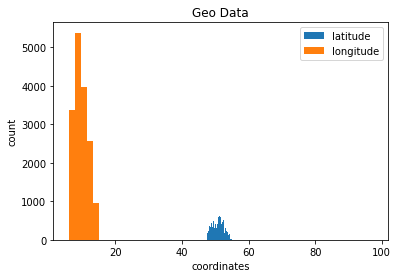

In [35]:
plt.hist(df_stations["latitude"], 50, label='latitude')
plt.hist(df_stations["longitude"], 50, label='longitude')
plt.legend(loc='upper right')
plt.title("Geo Data")
plt.xlabel('coordinates') 
plt.ylabel('count')
plt.show()

Bei Longitude ist ein Ausreißer beim Wert 0 zu erkennen. Diese werden im Folgenden gefiltert.
Ebenso sind unphysikalische Werte zu erkennen, welche ebenfalls korrigiert werden.

In [36]:
df_stations = df_stations.loc[(df_stations["longitude"] != 0.0) & (df_stations["latitude"] != 0.0)]
df_stations = df_stations.loc[(df_stations["latitude"] <= 90.0) & (df_stations["latitude"] >= -90.0) & (df_stations["longitude"] <= 180.0) & (df_stations["longitude"] >= -180.0)]

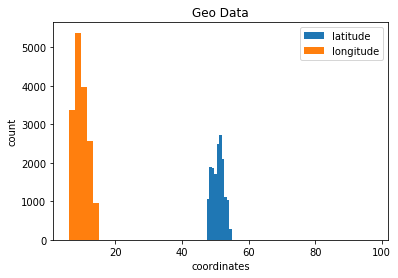

In [166]:
plt.hist(df_stations["latitude"], 10, label='latitude')
plt.hist(df_stations["longitude"], 50, label='longitude')
plt.legend(loc='upper right')
plt.title("Geo Data")
plt.xlabel('coordinates') 
plt.ylabel('count')
plt.show()

Jetzt sehen wir die korrekte Koordinaten Daten

e) Reichern Sie den Tankstellendatensatz um die Spalte state an, die das Bundesland enthalten soll, in dem sich die Tankstelle befindet. Erzeugen Sie durch Filterung einen DataFrame
namens df_stations_BY, der die Informationen zu allen Tankstellen in Bayern enthalt.

In [37]:
df_stations = df_stations.reset_index(drop=True)
df_stations.shape[0]

16247

In [38]:
df_stations[-10:].index

RangeIndex(start=16237, stop=16247, step=1)

In [74]:
# for i in tqdm(df_stations.index):
#     data = df_stations.iloc[i]
#     location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
#     adressData = location.raw["address"]
#     if "state" in adressData:
#         df_stations.at[i, "state"] = adressData["state"]

# df_stations["state"]

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


0                     Bayern
1                     Hessen
2        Nordrhein-Westfalen
3              Niedersachsen
4        Nordrhein-Westfalen
                ...         
16286     Schleswig-Holstein
16287          Niedersachsen
16288          Niedersachsen
16289          Niedersachsen
16290    Nordrhein-Westfalen
Name: state, Length: 16291, dtype: object

In [39]:
df_bundesland_plz = pd.read_csv("zuordnung_plz_ort_landkreis.csv")
df_bundesland_plz.head()

,osm_id,ags,ort,plz,landkreis,bundesland
0,1104550,8335001,Aach,78267,Landkreis Konstanz,Baden-Württemberg
1,1255910,7235001,Aach,54298,Landkreis Trier-Saarburg,Rheinland-Pfalz
2,62564,5334002,Aachen,52062,Städteregion Aachen,Nordrhein-Westfalen
3,62564,5334002,Aachen,52064,Städteregion Aachen,Nordrhein-Westfalen
4,62564,5334002,Aachen,52066,Städteregion Aachen,Nordrhein-Westfalen


In [40]:
plz_bundesland_dict = {}

for i, j in zip(df_bundesland_plz.plz, df_bundesland_plz.bundesland):
    plz_bundesland_dict[i] = j
    

In [41]:
df_stations["state"] = df_stations["post_code"].map(plz_bundesland_dict)
df_stations.isnull().sum()

Unnamed: 0            0
uuid                  0
name                  0
brand                 0
street                0
house_number          0
post_code             0
city                  1
latitude              0
longitude             0
first_active          0
openingtimes_json     0
state                39
dtype: int64

In [42]:
for i in tqdm(df_stations.loc[df_stations["state"].isnull()].index):
    data = df_stations.iloc[i]
    location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
    adressData = location.raw["address"]
    if "state" in adressData:
        df_stations.at[i, "state"] = adressData["state"]

df_stations["state"].isnull().sum()

100%|██████████| 39/39 [00:20<00:00,  1.93it/s]


0

In [43]:
df_stations[df_stations["state"].isnull()]

,Unnamed: 0,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json,state


In [44]:
df_stations.to_csv("State_checkpoint.csv", index=False)

In [178]:
df_stations = pd.read_csv("State_checkpoint.csv")

In [45]:
df_stations_BY = df_stations.loc[df_stations["state"] == "Bayern"]

In [5]:
df_stations.to_csv("Bayern_checkpoint.csv", index=False)

In [7]:
df_stations = pd.read_csv("State_checkpoint.csv")

Lesen Sie nun den Preise-Datensatz aus dem GitLab-Repository in einen DataFrame namens
df_prices_BY ein. Dieser wurde durch Filterung der auf der Tankerkonig-Seite verf ¨ ugbaren ¨
Preise-Datensatze erzeugt und enth ¨ alt die Angaben zur historischen Preisen und Preis ¨ anderungen ¨
an den Tankstellen in Bayern im Betrachtungszeitraum zwischen Januar 2018 und Mai 2021.

In [2]:
df_prices_BY = pd.read_csv("prices_BY.csv")

f) Untersuchen Sie die Kraftstoffpreise auf Ausreißer und entfernen Sie diese ggf.

In [46]:
df_prices_BY.head()

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2018-01-01 00:01:06+01,db9309c1-eb3f-4a2a-92ec-a374262facc9,1.274,0.000,0.000,1,0,0
1,2018-01-01 00:02:06+01,446bdcf5-9f75-47fc-9cfa-2c3d6fda1c3b,1.339,1.459,1.439,1,1,1
2,2018-01-01 00:03:05+01,a98ed5d0-261b-4311-beaf-85ee779fc4e0,1.289,1.439,1.419,1,1,1
3,2018-01-01 00:05:06+01,7fa4a726-3da5-4aca-afdb-161fbbac23b0,1.299,1.469,1.449,1,1,1
4,2018-01-01 00:07:06+01,742c6776-9f9e-45c9-87de-b27e3c5677a9,1.249,0.000,0.000,1,0,0


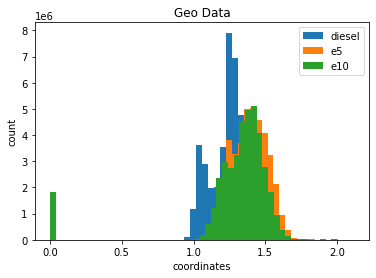

In [47]:
plt.hist(df_prices_BY["diesel"], 50, label='diesel')
plt.hist(df_prices_BY["e5"], 50, label='e5')
plt.hist(df_prices_BY["e10"], 50, label='e10')
plt.legend(loc='upper right')
plt.title("Geo Data")
plt.xlabel('coordinates') 
plt.ylabel('count')
plt.show()

In [5]:
df_prices_BY["e10"] = df_prices_BY["e10"].replace(0.000, np.nan)
df_prices_BY.loc[df_prices_BY["e10"] < 0.5] = np.nan
df_prices_BY["e5"] = df_prices_BY["e5"].replace(0.000, np.nan)
df_prices_BY.loc[df_prices_BY["e5"] < 0.5] = np.nan
df_prices_BY["diesel"] = df_prices_BY["diesel"].replace(0.000, np.nan)
df_prices_BY.loc[df_prices_BY["diesel"] < 0.5] = np.nan

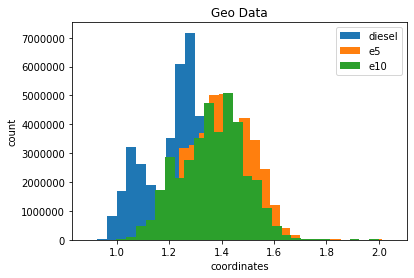

In [185]:
plt.hist(df_prices_BY["diesel"], 30, label='diesel')
plt.hist(df_prices_BY["e5"], 30, label='e5')
plt.hist(df_prices_BY["e10"], 30, label='e10')
plt.legend(loc='upper right')
plt.title("Geo Data")
plt.xlabel('coordinates') 
plt.ylabel('count')
plt.show()

g) Uberf ¨ uhren Sie die Spalte ¨ date in ein DateTime-Format.

In [6]:
df_prices_BY["date"] = pd.to_datetime(df_prices_BY["date"], infer_datetime_format=True, utc=True)
df_prices_BY["date"].head()

0   2017-12-31 23:01:06+00:00
1   2017-12-31 23:02:06+00:00
2   2017-12-31 23:03:05+00:00
3   2017-12-31 23:05:06+00:00
4   2017-12-31 23:07:06+00:00
Name: date, dtype: datetime64[ns, UTC]

### Aufgabe 2 
#### (Explorative Datenanalyse)
In dieser Aufgabe sind erste einfache Analysen durchzufuhren und Visualisierungen zu erstellen

a) Wie viele Tankstellen gibt es insgesamt in Deutschland? Wie viele pro Bundesland?

In [49]:
tankstellenDeutschland = len(df_stations)
tankstellenDeutschland

16247

In [50]:
# haeufigkeitTankstellen = {"Deutschland": 0, "Baden-Wuerttemberg": 0, "Bayern": 0, "Berlin": 0, "Brandenburg": 0, "Bremen": 0, "Hamburg": 0, "Hessen": 0, "Mecklenburg-Vorpommern": 0, "Niedersachsen": 0, "Nordrhein-Westfalen": 0, "Rheinland-Pfalz": 0, "Saarland": 0, "Sachsen": 0, "Sachsen-Anhalt": 0, "Schleswig-Holstein": 0, "Thueringen": 0}

# for x in df_stations["state"]:
#     if x == "Baden-Württemberg":
#         haeufigkeitTankstellen["Baden-Wuerttemberg"] += 1
#     if x == "Bayern":
#         haeufigkeitTankstellen["Bayern"] += 1
#     if x == "Berlin":
#         haeufigkeitTankstellen["Berlin"] += 1
#     if x == "Brandenburg":
#         haeufigkeitTankstellen["Brandenburg"] += 1
#     if x == "Bremen":
#         haeufigkeitTankstellen["Bremen"] += 1
#     if x == "Hamburg":
#         haeufigkeitTankstellen["Hamburg"] += 1
#     if x == "Hessen":
#         haeufigkeitTankstellen["Hessen"] += 1
#     if x == "Mecklenburg-Vorpommern":
#         haeufigkeitTankstellen["Mecklenburg-Vorpommern"] += 1
#     if x == "Niedersachsen":
    #     haeufigkeitTankstellen["Niedersachsen"] += 1
    # if x == "Nordrhein-Westfalen":
    #     haeufigkeitTankstellen["Nordrhein-Westfalen"] += 1
    # if x == "Rheinland-Pfalz":
    #     haeufigkeitTankstellen["Rheinland-Pfalz"] += 1
    # if x == "Saarland":
    #     haeufigkeitTankstellen["Saarland"] += 1
    # if x == "Sachsen":
    #     haeufigkeitTankstellen["Sachsen"] += 1
    # if x == "Sachsen-Anhalt":
    #     haeufigkeitTankstellen["Sachsen-Anhalt"] += 1
    # if x == "Schleswig-Holstein":
    #     haeufigkeitTankstellen["Schleswig-Holstein"] += 1
    # if x == "Thüringen":
    #     haeufigkeitTankstellen["Thueringen"] += 1
    # haeufigkeitTankstellen["Deutschland"] += 1

bundeslandListe = list(df_stations['state'].value_counts().index)

def Convert(lst):
    res_dct = {lst[i]: 0 for i in range(0, len(lst), 1)}
    return res_dct

haeufigkeitTankstellen = Convert(bundeslandListe)

for x in df_stations["state"]:
    if x in haeufigkeitTankstellen:
        haeufigkeitTankstellen[x] += 1


haeufigkeitTankstellen

{'Nordrhein-Westfalen': 3350,
 'Bayern': 2777,
 'Baden-Württemberg': 2103,
 'Niedersachsen': 2056,
 'Hessen': 1280,
 'Rheinland-Pfalz': 859,
 'Schleswig-Holstein': 660,
 'Sachsen': 618,
 'Sachsen-Anhalt': 476,
 'Brandenburg': 459,
 'Thüringen': 443,
 'Mecklenburg-Vorpommern': 373,
 'Berlin': 303,
 'Hamburg': 214,
 'Saarland': 172,
 'Bremen': 104}

b) Welches sind die zehn Tankstellenmarken mit den meisten Niederlassungen in Deutschland?
Wie viele Niederlassungen sind es jeweils?

In [51]:
meisteMarken = list(df_stations['brand'].value_counts()[0:10].index)

def Convert(lst):
    res_dct = {lst[i]: 0 for i in range(0, len(lst), 1)}
    return res_dct

lst = Convert(meisteMarken)

for x in df_stations["brand"]:
    if x in lst:
        lst[x] += 1

lst

{'ARAL': 2421,
 'SHELL': 1848,
 'ESSO': 1134,
 'TOTAL': 921,
 'AVIA': 730,
 'JET': 697,
 'OTHER': 658,
 'STAR': 577,
 'BFT': 485,
 'AGIP': 457}

c) Welcher Anteil der Tankstellen hat sonntags geoffnet?

In [52]:
openingTimes = df_stations['openingtimes_json']
openOnSunday = {"Sonntags_geöffnet": 0, "Sonntags_geschlossen": 0}
errorData = {"Keine_Öffnungszeit": 0, "Fehlerhaft": 0}

for x in openingTimes:
    if x != "empty":
        if "openingTimes" in json.loads(x):
            foundSunday = False
            for y in json.loads(x)["openingTimes"]:
                bitValue = y["applicable_days"]
                mask = 1 << 6
                if (bitValue & mask == mask):
                    openOnSunday["Sonntags_geöffnet"] += 1
                    foundSunday = True
                    break
            if (foundSunday == False):
                openOnSunday["Sonntags_geschlossen"] += 1
        else:
            errorData["Fehlerhaft"] += 1
    else:
        errorData["Keine_Öffnungszeit"] += 1

openOnSunday

{'Sonntags_geöffnet': 8403, 'Sonntags_geschlossen': 594}

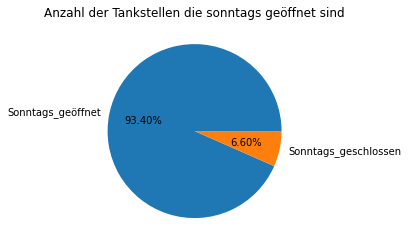

In [53]:
def pie_label_formatter(x):
    return '{:.2f}%'.format(x)

plt.pie(openOnSunday.values(), labels = openOnSunday.keys(), autopct=pie_label_formatter)
plt.title("Anzahl der Tankstellen die sonntags geöffnet sind")
plt.show()

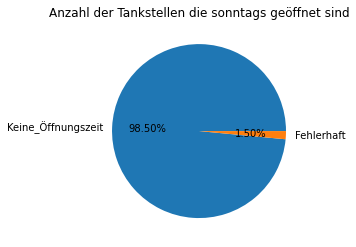

In [54]:
plt.pie(errorData.values(), labels = errorData.keys(), autopct=pie_label_formatter)
plt.title("Anzahl der Tankstellen die sonntags geöffnet sind")
plt.show()

d) Visualisieren Sie in einem Kreisdiagramm die Zusammensetzung des Marktes in freie Tankstellen und Markentankstellen. Nehmen Sie vereinfachend an, dass eine Tankstelle dann
eine freie Tankstelle ist, wenn sie gemaß der Spalte ¨ brand einer Marke angehort, die bun- ¨
desweit hochstens 20 Niederlassungen betreibt.

In [55]:
brand = list(df_stations['brand'].value_counts().index)

def Convert(lst):
    res_dct = {lst[i]: 0 for i in range(0, len(lst), 1)}
    return res_dct

lst = Convert(brand)

for x in df_stations["brand"]:
    if x in lst:
        lst[x] += 1

tankstellenListe = {"Markentankstellen": 0, "Freie Tankstellen": 0}

for x in lst.values():
    if x > 20:
        tankstellenListe["Markentankstellen"] += x
    else:
        tankstellenListe["Freie Tankstellen"] += x
tankstellenListe

{'Markentankstellen': 14422, 'Freie Tankstellen': 1825}

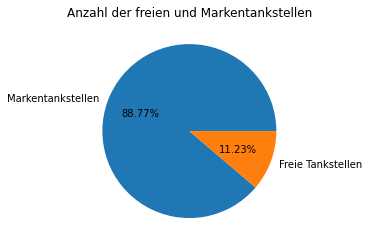

In [56]:
plt.pie(tankstellenListe.values(), labels = tankstellenListe.keys(), autopct=pie_label_formatter)
plt.title("Anzahl der freien und Markentankstellen")
plt.show()

e) Wie haufig wird an den bayerischen Tankstellen durchschnittlich pro Tag im Betrachtungs- ¨
zeitraum ein Datensatz an die Markttransparenzstelle fur Kraftstoffe ¨ ubermittelt? 

In [9]:
TagesDurchschnitt = df_prices_BY["date"].groupby(df_prices_BY["date"].dt.date).count()
TagesDurchschnitt

date
2017-12-31       47
2018-01-01    22767
2018-01-02    26726
2018-01-03    25916
2018-01-04    26315
              ...  
2021-05-27    40995
2021-05-28    41213
2021-05-29    40143
2021-05-30    37518
2021-05-31    39738
Name: date, Length: 1248, dtype: int64

In [10]:
TagesDurchschnitt.mean()

32029.253205128207

f) In welchen zehn bayerischen Stadten war der durchschnittliche Diesel-Preis im Betrach- ¨
tungszeitraum 2018-2021 am hochsten und wie hoch war er jeweils? In welchen zehn ¨
Stadten war er am geringsten und wie hoch war er jeweils? 

In [59]:
combinedStations = df_prices_BY.groupby("station_uuid")["diesel"].mean()

In [60]:
combined_df = pd.DataFrame(combinedStations)
combined_df = combined_df.reset_index()

In [61]:
combined_df.rename(columns = {"station_uuid":"uuid"}, inplace="True")

In [62]:
combined_df = combined_df.merge(df_stations[["uuid", "city"]])
combined_df = combined_df.groupby("city")["diesel"].mean()
combined_df = pd.DataFrame(combined_df)
combined_df = combined_df.reset_index()
#combined_df.dropna(subset=["diesel"], inplace=True)
#TODO drop 2017

In [63]:
combined_df.to_csv("combined_df.csv")

In [64]:
combined_df.sort_values(by=["diesel"], inplace=True, ascending=False)
combined_df[0:10]

,city,diesel
475,ILLSCHWANG,1.524327
411,HAUSEN BEI WUERZBURG,1.521027
531,KLEINLANGHEIM - HAIDT (SUED),1.502727
567,LANDSBERG LECH,1.501544
121,BERGEN / CHIEMGAU,1.497545
566,LANDSBERG AM LECH,1.496804
709,NEUFAHRN B.FREISING,1.493707
311,FUERHOLZEN,1.487344
509,KIEFERSFELDEN,1.480869
784,OHRENBACH,1.451928


In [65]:
combined_df.sort_values(by=["diesel"], ascending=True).head(10)

,city,diesel
1030,THEILENHOFEN,0.606736
329,GAUKOENIGSHOFEN,0.619032
1113,WASSERBURG,0.969117
507,KEMNATH,0.976028
726,NEUSORG,1.052291
1095,WAGENHOFEN,1.101939
517,KIRCHENLAMITZ,1.102472
1171,WOLKERTSHOFEN,1.106573
738,NIEDERFUELLBACH,1.114648
977,SENGENTHAL,1.121639


g) Erstellen Sie mit folium eine interaktive Karte, auf der die einzelnen Tankstellen in Bayern
als Marker (in einem Marker-Cluster) eingezeichnet sind. Beim Klick auf einen Marker soll
der Name der Tankstelle und deren Adresse angezeigt werden.

In [66]:
df_stations_BY.head()

,Unnamed: 0,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json,state
0,0,0e18d0d3-ed38-4e7f-a18e-507a78ad901d,OIL! Tankstelle München,OIL!,EVERSBUSCHSTRASSE 33,0,80999,MUENCHEN,48.180700,11.460900,1970-01-01 01:00:00+01,"{""openingTimes"":[{""applicable_days"":192,""perio...",Bayern
15,15,e4e50be1-a0dd-4d07-95d9-de4d6573cc17,Aral Tankstelle,ARAL,AICHACHER STRASSE,26,86316,FRIEDBERG,48.361404,10.987790,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":1,""periods...",Bayern
16,16,e4e48d10-0b37-4ecf-a0bd-552b0302a4af,Kirchdorf Hauptstraße 1,OMV,HAUPTSTR.,1,85414,KIRCHDORF,48.458410,11.652600,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",Bayern
23,23,e4b3161b-269e-41f9-8c56-d813a6733668,TotalEnergies Muenchen,TOTAL,LEONRODSTR. 48,0,80636,MUENCHEN,48.157499,11.543893,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",Bayern
27,27,e5bdb1cc-d078-40eb-86f6-35a000c3828c,AVIA XPress Automatenstation,AVIA XPRESS,COBURGER STRASSE,36,96237,EBERSDORF B. COBURG,50.222420,11.058580,2014-03-18 16:45:31+01,empty,Bayern


In [68]:
df_landkreise = pd.read_csv("zuordnung_plz_ort_landkreis.csv")
df_landkreise.rename(columns = {"plz":"post_code"}, inplace="True")
type(df_landkreise["post_code"][0])

numpy.int64

In [209]:
# #TODO mach mal
# df_stations_BY.dropna(subset = ["post_code"], inplace=True)
# np.isnan(df_stations_BY['post_code']).sum()

In [210]:
# df_stations_BY['post_code']=df_stations_BY['post_code'].astype(int)
# df_stations_BY.head()

In [69]:
df_stations_BY = df_stations_BY.merge(df_landkreise[["post_code", "landkreis"]])
df_stations_BY = pd.DataFrame(df_stations_BY)
df_stations_BY = df_stations_BY.reset_index()

In [70]:
landkreise = list(df_stations_BY['landkreis'].value_counts().index)
len(landkreise)

71

In [214]:
m = folium.Map(location=[48.9478033183036, 11.404411169316944], zoom_start=7, tiles="openstreetmap")

for x in landkreise:
    marker_cluster = MarkerCluster(name = x).add_to(m)
    for i in df_stations_BY.loc[df_stations_BY["landkreis"] == x].index:
        folium.Marker([df_stations_BY["latitude"][i], df_stations_BY["longitude"][i]], 
        popup=df_stations_BY["name"][i] + " " + df_stations_BY["street"][i] + " " + str(df_stations_BY["post_code"][i]) + " " + df_stations_BY["city"][i]).add_to(marker_cluster)

In [215]:
m

### Aufgabe 3
#### (Analyse der historischen Entwicklung der Kraftstoffpreise)

a) In welchem Monat im Betrachtungszeitraum waren die Kraftstoffpreise fur Diesel in Bay- ¨
ern durchschnittlich am hochsten? In welchem am geringsten? Wie hoch waren die durch- ¨
schnittlichen Preise jeweils?

In [17]:
monthPrices = df_prices_BY.resample(rule='M', on='date')['diesel'].mean()
monthPrices_df = pd.DataFrame(monthPrices)
monthPrices_df = monthPrices_df.reset_index()

In [22]:
monthPrices_df.sort_values(by=["diesel"], inplace=True, ascending=False)
monthPrices_df.head()

,date,diesel
11,2018-11-30 00:00:00+00:00,1.505811
10,2018-10-31 00:00:00+00:00,1.441287
9,2018-09-30 00:00:00+00:00,1.387470
12,2018-12-31 00:00:00+00:00,1.371994
41,2021-05-31 00:00:00+00:00,1.333518


In [23]:
monthPrices_df.tail()

,date,diesel
30,2020-06-30 00:00:00+00:00,1.079502
33,2020-09-30 00:00:00+00:00,1.055030
35,2020-11-30 00:00:00+00:00,1.054675
29,2020-05-31 00:00:00+00:00,1.045193
34,2020-10-31 00:00:00+00:00,1.043569


b) Ermitteln Sie die Jahresdurchschnitte fur die einzelnen Kraftstoffsorten in den Jahren 2018- ¨
2021 fur die bayerischen Tankstellen. Visualisieren Sie diese in einem geeigneten Dia- ¨
gramm. Lassen sich Trends erkennen?

In [40]:
#TODO

c) Visualisieren Sie auf geeignete Weise den zeitlichen Verlauf der Preise fur die Kraftstoffe ¨
Diesel und Super E5 und Super E10 an den bayerischen Tankstellen zwischen 2018 und
2021. Beschreiben und interpretieren Sie Ihre Beobachtungen.

In [41]:
#TODO

### Aufgabe 4
#### (Abhangigkeit zwischen dem Roh ¨ olpreis und den Kraftstoffpreisen)

a) Untersuchen Sie jeweils den Zusammenhang zwischen den Kraftstoffpreisen fur Diesel bzw. ¨
Super E5 und dem Roholpreis. Berechnen Sie dazu die Tagesmittelwerte f ¨ ur die Kraftstoff- ¨
preise fur alle Tage im Betrachtungszeitraum 2018-2021 (f ¨ ur die bayerischen Tankstellen) ¨
und stellen Sie diese jeweils den Tagesschlusskursen fur die Roh ¨ olsorte Brent Crude Oil ¨
(offentlich verf ¨ ugbar) in zwei Streudiagrammen (eines f ¨ ur Diesel und eines f ¨ ur E5) ge- ¨
genuber. Laden Sie die verwendeten ¨ Olpreis-Daten in Form einer CSV-Datei mit Ihrer Ab- ¨
gabe auf Moodle hoch.

In [42]:
#TODO

b) Berechnen Sie jeweils fur Diesel und E5 den empirischen Korrelationskoeffizienten zwi- ¨
schen den Roholpreisen und den Tagesmittelwerten der Kraftstoffpreise.

In [43]:
#TODO

c) Diskutieren Sie, ob lineare Modelle sinnvoll waren, um die Zusammenh ¨ ange zwischen dem ¨
Roholpreis und den Preisen f ¨ ur Diesel bzw. E5 darzustellen.

In [44]:
#TODO

### Aufgabe 5
#### (Einfluss des Wettbewerbs auf die Kraftstoffpreise in Bayern)
Untersuchen Sie, welchen Einfluss der Wettbewerb zwischen mehreren Tankstellen auf die Preisgestaltung hat. Ermitteln Sie dazu zunachst f ¨ ur jede Tankstelle in Bayern, wie viele Tankstellen ¨
sich im Umkreis von 5km Umgebung zu ihr befindet. Speichern Sie diese Angabe in einer Spalte namens neighbors. Speichern Sie den resultierenden DataFrame df stations BY als
CSV-Datei namens stations BY.csv und laden Sie diese mit Ihrer Abgabe auf Moodle hoch.
Stellen Sie zunachst m ¨ ogliche Hypothesen auf und untersuchen Sie diese anschließend, indem Sie ¨
geeignete Auswertungen und Visualisierungen erstellen.

In [45]:
#TODO

### Aufgabe 6
#### (Tanken in Amberg, Interaktives Diagramm)
Herr Sparfuchs, der als Rentner zeitlich flexibel ist, mochte wissen, wann und wo er in Am- ¨
berg derzeit am gunstigsten tanken kann. Erstellen Sie dazu ein geeignetes interaktives Dia- ¨
gramm mit Plotly, um die Kraftstoffpreise an den Tankstellen in Amberg zu analysieren, und
leiten Sie Empfehlungen fur Herrn Sparfuchs ab. Erstellen Sie f ¨ ur die Analyse zwei DataFrames ¨
namens df stations amberg und df prices amberg, die aus Filterung der Tankstellenund Preisdatensatze hervorgehen, und verwenden Sie ausschließlich diese f ¨ ur die Erzeugung des ¨
Plotly-Diagramms. Dokumentieren Sie Ihre Analyseergebnisse.

In [46]:
#TODO